# **Import and install libraries**

In [ ]:
!pip install snscrape
!pip install emot
!pip3 install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 KB 3.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 KB 3.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#libraries needed
import snscrape
import pandas as pd
import snscrape.modules.twitter as sntwitter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tqdm
from tqdm.notebook import tqdm_notebook

from emot.emo_unicode import UNICODE_EMOJI
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
eng_stop_words = list(stopwords.words('english'))
emoji = list(UNICODE_EMOJI.keys())

import string
import re
import textblob
from textblob import TextBlob

from wordcloud import WordCloud, STOPWORDS
from emot.emo_unicode import UNICODE_EMOJI

porter = PorterStemmer()

lemmatizer = WordNetLemmatizer() 

from wordcloud import ImageColorGenerator
from PIL import Image

import warnings
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')
#df.to_csv('/content/drive/MyDrive/sentiment2.csv')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounted at /content/drive


In [ ]:
!pip install --upgrade snscrape

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Scraping tool**

In [ ]:
#**Using the snscraper to screpe tweets**
# Creating a search filters to search by
QUERY = '#israel'
FILTERS = 'filter:safe filter:has_engagement -filter:retweets -filter:replies -filter:quote'
start_date = '2019-01-01'
end_date = '2023-01-13'

# Creating list to append tweet data to
tweet_list = []

# Using TwitterSearchScraper to scrape data and append tweets to list
for tweet in tqdm(snscrape.modules.twitter.TwitterSearchScraper(f'{QUERY} since:{start_date} until:{end_date} {FILTERS} lang:en').get_items(), total=150000):
    tweet_list.append([tweet.id, 
                        tweet.user.id,
                        tweet.username,
                        tweet.date, 
                        tweet.url, 
                        tweet.content,
                        tweet.hashtags,
                        tweet.sourceLabel,
                        tweet.source,
                        tweet.place,
                        tweet.retweetCount, 
                        tweet.likeCount, 
                        tweet.replyCount, 
                        tweet.quoteCount, 
                        tweet.user.friendsCount,          
                        tweet.user.followersCount, 
                        tweet.user.statusesCount, 
                        tweet.user.favouritesCount,
                        tweet.user.listedCount, 
                        tweet.user.verified, 
                        tweet.user.created
                        ])
tweets_df = pd.DataFrame(tweet_list, 
    columns=[
                        'tweet.id',
                        'tweet_user_id'
                        'tweet.date',  
                        'tweet.url', 
                        'tweet.content',
                        'tweet.profile.hashtags',
                        'tweet.profile.sourceLabel',
                        'tweet.profile.source',
                        'tweet.profile.place',
                        'tweet.stat.retweetCount', 
                        'tweet.stat.likeCount', 
                        'tweet.stat.likeCount', 
                        'tweetstat..replyCount', 
                        'tweet.stat.quoteCount', 
                        'tweet.user.friendsCount',          
                        'tweet.user.followersCount', 
                        'tweet.user.statusesCount', 
                        'tweet.user.favouritesCount',
                        'tweet.user.listedCount', 
                        'tweet.user.verified', 
                        'tweet.user.created'])

tweets_df.to_csv('tweet_Data_Set_full_Data.csv')
tweets_df.to_csv('/content/drive/MyDrive/tweet_Data_Set_full_Data.csv')

In [ ]:
tweets =pd.read_csv('/content/drive/MyDrive/tweet_Data_Set_full_Data.csv')


In [ ]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172506 entries, 0 to 172512
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   tweet.id                    172506 non-null  object 
 1   tweet.date                  172506 non-null  object 
 2   tweet.content               172506 non-null  object 
 3   tweet.hashtags              172506 non-null  object 
 4   tweet.sourceLabel           172506 non-null  object 
 5   tweet.place                 172506 non-null  object 
 6   tweet.retweetCount          172506 non-null  float64
 7   tweet.likeCount             172506 non-null  float64
 8   tweet.replyCount            172506 non-null  float64
 9   tweet.quoteCount            172506 non-null  float64
 10  tweet.user.friendsCount     172506 non-null  float64
 11  tweet.user.followersCount   172506 non-null  object 
 12  tweet.user.statusesCount    172506 non-null  object 
 13  tweet.user.fav

In [ ]:
tweets_copy = tweets.copy()

# **Data PreProcess**
This involves this neccessay steps before carrying out the sentiment analysis:

 
1.   remove the empty columns and fill missing values
2.   Extracting twitter handle from the url links
3.   Group source of tweet categories
4.   Extracting tags
5.   Handling the date and hashtag columns
6.   Extracting location of the tweet
7.   Cleaning the tweet :
     Removin the stop words
     Tokenizing and Lemmitizing words

In [ ]:
#remove the empty columns
tweets.dropna(subset=['tweet.content'], inplace=True)
tweets.dropna(subset=['tweet.likeCount'], inplace=True)
#fill missing values
tweets["tweet.hashtags"].fillna(value='Unknown', inplace=True)
tweets["tweet.place"].fillna(value='Unknown', inplace=True)
#Extracting thw user @Twitter Handle 
tweets['tweet.url']
tweets["tweet.User.TwitterHandle"] = tweets["tweet.url"].str.extract(r"https://twitter.com/(?P<username>[^/]+)")


In [ ]:
#assigning unique id to users
import hashlib
user_names = tweets["tweet.User.TwitterHandle"].unique()
user_name_to_id = {name: int(hashlib.sha1(name.encode()).hexdigest(), 16) % (10 ** 8) for name in user_names}
tweets["tweet.User_id"] = tweets["tweet.User.TwitterHandle"].map(user_name_to_id)
tweets["tweet.User_id"].value_counts()

In [ ]:
#categorizing the sourceLabel column to four categories
tweets['tweet.sourceLabel'] = np.where(tweets['tweet.sourceLabel'].str.contains('mac|ipad|iphone', case=False), 'Twitter for Apple Devices',
                                   np.where(tweets['tweet.sourceLabel'].isin(['Twitter Web App','Twitter for Android']), tweets['tweet.sourceLabel'], 'Other'))
tweets['tweet.sourceLabel'].value_counts()

In [ ]:
tweets['tweet.sourceLabel'].value_counts().to_frame()

,tweet.sourceLabel
Twitter Web App,75087
Other,38122
Twitter for Apple Devices,30354
Twitter for Android,28943


In [ ]:
tweets.to_csv('tweets Data Set_16_11.csv')

In [ ]:
tweets = pd.read_csv('/content/drive/MyDrive/tweets Data Set_16_11.csv')

**Hashtags column handling**

in this part i will try to find the most common tags associated with israel

In [ ]:
#Extracting the Hashtags from the content and counting the most frequent hashtags and creating a df of the result
hashtags = tweets['tweet.content'].str.extractall(r'#(\w+)')
hashtag_counts = hashtags[0].value_counts()
hashtag_counts_df = pd.DataFrame(columns=['hashtag', 'count'])
hashtag_counts_df['hashtag'] = hashtag_counts.index
hashtag_counts_df['count'] = hashtag_counts.values
hashtag_counts_df.to_csv('hashtag_counts.csv', index=False)

hashtag_counts.head()


In [ ]:
hashtag_counts_df['hashtag'] = hashtag_counts_df['hashtag'].str.lower()
hashtag_counts_df['hashtag'] = hashtag_counts_df['hashtag'].str.strip()


In [ ]:
#Extracting all the Hash tags the contain israel
israel_words = hashtag_counts[hashtag_counts["hashtag"].str.contains("israel")]
israel_counts = israel_words.groupby('hashtag').sum().sort_values(by='count', ascending=False)
israel_counts


In [ ]:
israel_counts =israel_counts.reset_index('hashtag')

In [ ]:
def format_words(string):
    return string.replace("of", "").replace("in", "").replace("israeli", "").replace("israel", "")

israel_counts["hashtag"] = israel_counts["hashtag"].apply(format_words)

In [ ]:
israel_counts.dropna(subset=["hashtag"], inplace=True)


In [ ]:
israel_counts = israel_counts.iloc[2:]
israel_counts

**Date Parts extraction**

In [ ]:
tweets = pd.read_csv('/content/tweets.18_01.01_50.csv')

In [ ]:
tweets["tweet.user.created"] = pd.to_datetime(tweets["tweet.user.created"], utc=True)
tweets["tweet.date"] = pd.to_datetime(tweets["tweet.date"], utc=True)
tweets.info()

In [ ]:
#extracting time part from tweet created date and user tweeter "birth"
tweets['tweet.date.Hour'] = tweets['tweet.date'].dt.hour
tweets['tweet.date.Year'] = tweets['tweet.date'].dt.year  
tweets['tweet.date.Month'] = tweets['tweet.date'].dt.month
tweets['tweet.date.MonthName'] = tweets['tweet.date'].dt.month_name()
tweets['tweet.date.MonthDay'] = tweets['tweet.date'].dt.day
tweets['tweet.date.DayName'] = tweets['tweet.date'].dt.day_name()
tweets['tweet.date.Week'] = tweets['tweet.date'].dt.isocalendar().week

#extracting time part from user created date
tweets['tweet.user.created.Hour'] = tweets['tweet.user.created'].dt.hour
tweets['tweet.user.created.Year'] = tweets['tweet.user.created'].dt.year  
tweets['tweet.user.created.Month'] = tweets['tweet.user.created'].dt.month
tweets['tweet.user.created.MonthName'] = tweets['tweet.user.created'].dt.month_name()
tweets['tweet.user.created.MonthDay'] = tweets['tweet.user.created'].dt.day
tweets['tweet.user.created.DayName'] = tweets['tweet.user.created'].dt.day_name()
tweets['tweet.user.created.Week'] = tweets['tweet.user.created'].dt.isocalendar().week

In [ ]:
tweets.to_csv('tweets.18_01.01_50.csv')

In [ ]:
# #tweets.to_csv('tweets_data_set_after_date_extraction_18_01_10_04.csv')
# tweets= pd.read_csv('/content/drive/MyDrive/tweets_data_set_after_date_extraction_18_01_10_04.csv')

In [ ]:
tweets.head()

**Location cleaning**

Extracting from the place column, the location where the user logged from

In [ ]:
place = tweets['tweet.place'].unique()
#print(place)
tweets['tweet.Location_logged'] = tweets['tweet.place'].str.extract(r"country='([\w\s]+)'")
tweets["tweet.Location_logged"] = tweets["tweet.Location_logged"].fillna('Unknown')

In [ ]:
tweets.info()

**Creating a new column called engagemt rate**

Engagement rate is a metric used to assess the average number of interactions the social media content receives per follower. Engagement rate on Twitter is calculated as the sum of: (Likes + Retweets + Quotes + Replies) divided by the number of tweets, then by the total number of followers, then multiplied by 100

In [ ]:
#Calcultatin the Engament rate
def engagement_rate(x):
    if x['tweet.user.statusesCount'] == 0 or x['tweet.user.followersCount'] == 0:
        return 0
    engagement = x['tweet.retweetCount'] + x['tweet.likeCount'] + x['tweet.replyCount'] + x['tweet.quoteCount']
    engagement = engagement / x['tweet.user.statusesCount']
    engagement = engagement / x['tweet.user.followersCount']
    engagement = engagement * 100
    return engagement
tweets['engagement_rate'] = tweets.apply(lambda x: engagement_rate(x), axis=1)


**tweet cleaning**

In [ ]:
# #removing non english tweets
# tweets = tweets.loc[tweets['lang'] == 'en']
tweets_copy = tweets.copy()

In [ ]:
#import re

non_english_pattern = '[^\x00-\x7F]+'

# Create a Boolean mask indicating the rows that contain non-English characters
non_english_mask = tweets['tweet.content'].str.contains(non_english_pattern, na=False)

# Remove the non-English rows from the DataFrame
tweets = tweets[~non_english_mask]
tweets.info()



In [ ]:
# sorting the data by date and Removing the duplicated tweets Keeping only the first
tweet = tweets.sort_values(by='tweet.date', ascending = False)
duplicate_tweets = tweets[tweets.duplicated(subset='tweet.content', keep=False)]
# tweets = tweets.drop(columns=['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1'], axis=1)
tweets.info()


In [ ]:
#Creating a new column called processed tweets and removing unwanted chars from the text:
def remove_usernames_links(tweet):
 tweet = re.sub('@[^\s]+','',str(tweet))
 tweet = re.sub('#','',str(tweet))
 tweet = re.sub('“','',str(tweet))
 tweet = re.sub('!','',str(tweet))
 tweet = re.sub('http[^\s]+','',str(tweet))
 tweet = re.sub('\n','',str(tweet))
 tweet = re.sub('amp','',str(tweet))
 tweet = re.sub('&;','and',str(tweet))

 return tweet
tweets['processed_tweet'] = tweets['tweet.content'].apply(remove_usernames_links)
#tweets['processed_tweet']

In [ ]:
#removing emojis and others symbols from the text
import re
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)
tweets['processed_tweet'] = tweets['processed_tweet'].apply(remove_emojis)
tweets['processed_tweet']

0         As long as  keeps vilifying Israel, I will kee...
1         Written records of biblical King David discove...
2         Friday's Haaretz (Israel) news TomorrowsPapers...
3         The great Civil Rights activist, Reverend Dr. ...
4         Popular Dutch right wing wizard Geert Wilders ...
                                ...                        
172501    Israel's Supreme Court rules to allow surrogac...
172502    A lot of people are special needs in the Ukrai...
172503    "The poet and Palestinian citizen of Israel wa...
172504    Israeli breakthrough migraine treatment 'zaps'...
172505    Iran-controlled Lebanon is sinking in a major ...
Name: processed_tweet, Length: 109487, dtype: object

In [ ]:
# function for preprocessing tweet in preparation for sentiment analysis
def Processedtweets(text):
    #changing tweet text to small letters
    text = text.lower()
    # Removing @ and links 
    text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) |(\w+:\/\/\S+)", " ", text).split())
    text = re.sub(r'[0-9]+', '', text)
    # removing repeating characters
    text = re.sub(r'\@\w+|\#\w+|\d+', '', text)
    # removing punctuation and numbers
    punct = str.maketrans('', '', string.punctuation+string.digits)
    text = text.translate(punct)
    # tokenizing words to break down a piece of text into smaller units and removing stop words from the tweet text
    tokens = word_tokenize(text)  
    filtered_words = [w for w in tokens if w not in eng_stop_words]
    filtered_words = [w for w in filtered_words if w not in emoji]
    # lemmetizing words to reduce the word to its base form
    lemmatizer = WordNetLemmatizer() 
    lemma_words = [lemmatizer.lemmatize(w) for w in filtered_words]
    text = " ".join(lemma_words)
    return text
tweets['processed_tweet'] = tweets['processed_tweet'].apply(Processedtweets)
#tweets['processed_tweet']

In [ ]:
tweets = tweets.sort_values(by='tweet.date')


In [ ]:
tweets.to_csv('tweets_2020_after_text_process_11:17.csv')

In [ ]:
# #another data wrangling process
# # extracting tweets about isreal and palestine (future comparison)
# def extract_israel(n):
#   n = str(n)
#   resp = n.lower().find("israel")
#   if resp != -1:
#     return "Israel"
#   else: 
#     return None

# def extract_Palestine(n):
#   n = str(n)
#   resp = n.lower().find("palestine")
#   if resp != -1:
#     return "Palestine"
#   else:
#     return None
# #applying the function
# tweets['Israel'] = tweets['tweet.content'].apply(extract_israel) 
# tweets['Palestine'] = tweets['tweet.content'].apply(extract_Palestine) 
#another data wrangling process
# # replacing empty values with Empty
# tweets['Palestine'] = tweets['Palestine'].fillna('Empty')
# tweets['Israel'] = tweets['Israel'].fillna('Empty')

In [ ]:
# convert the tweet text into a string separate with " "
tweets_string = tweets['processed_tweet'].astype(str).tolist()
tweets_string = " ".join(tweets_string)

In [ ]:
from collections import Counter
#Finding the most repeated word in tweets
# Split the tweets_string into words
tweets_list = tweets_string.split()

# Count the frequency of each word
word_counts = Counter(tweets_list)

# Print the word counts
print(word_counts)
#print(word_counts.most_common(10))

In [ ]:
for word in list(word_counts):
    if word == "israeli":
        word_counts["israel"] += word_counts[word]
        del word_counts[word]
    if word == "jewish":
        word_counts["jew"] += word_counts[word]    
        del word_counts[word]
    elif word == "palestinian":
        word_counts["palestine"] += word_counts[word]
        del word_counts[word]
    elif word == "via":
        del word_counts[word]
    elif word == "u":
        del word_counts[word]
print(word_counts)

Counter({'israel': 132969, 'palestine': 23737, 'jew': 9676, 'iran': 8855, 'gaza': 6598, 'new': 6205, 'jerusalem': 6168, 'minister': 5236, 'attack': 5228, 'state': 5102, 'ukraine': 5050, 'country': 4988, 'year': 4891, 'people': 4767, 'world': 4694, 'russia': 4276, 'say': 4261, 'covid': 4204, 'one': 3944, 'day': 3735, 'india': 3731, 'usa': 3622, 'arab': 3528, 'first': 3527, 'time': 3486, 'report': 3452, 'force': 3445, 'hamas': 3137, 'war': 3122, 'syria': 3121, 'today': 3074, 'idf': 3062, 'two': 3048, 'news': 3020, 'right': 3018, 'terrorist': 3014, 'security': 2985, 'lebanon': 2944, 'military': 2891, 'said': 2808, 'president': 2795, 'uae': 2773, 'killed': 2733, 'peace': 2680, 'apartheid': 2675, 'visit': 2666, 'west': 2584, 'breaking': 2568, 'government': 2529, 'defense': 2484, 'support': 2463, 'child': 2378, 'week': 2359, 'un': 2261, 'prime': 2242, 'bank': 2126, 'rocket': 2115, 'deal': 2114, 'turkey': 2103, 'group': 2103, 'would': 2079, 'last': 2072, 'may': 1979, 'like': 1970, 'internatio

In [ ]:
word_counts_df = pd.DataFrame.from_dict(word_counts, orient='index', columns=['count'])
word_counts_df = word_counts_df.reset_index()
word_counts_df.columns = ['word', 'count']
word_counts_df.to_csv('common_word_tweets_counts_df.csv')

In [ ]:
# Function for polarity score
def polarity(tweet):
    return TextBlob(tweet).sentiment.polarity

# Function to get sentiment type
#setting the conditions
def sentimenttextblob(polarity):
    if polarity < 0:
        return "Negative"
    elif polarity == 0:
        return "Neutral"
    else:
        return "Positive"  


In [ ]:
# using the functions to get the polarity and sentiment
tweets['Polarity'] = tweets['processed_tweet'].astype(str).apply(polarity)
tweets['Sentiment'] = tweets['Polarity'].apply(sentimenttextblob)
sent = tweets['Sentiment'].value_counts()
sent

Neutral     47522
Positive    40274
Negative    21691
Name: Sentiment, dtype: int64

In [ ]:
tweets.head()

# **Data Visualization**
The major part of visualization is done in a dashboard on Power BI but some simple visualization were done in this notebook.
Resources on customizing word cloud can be found here https://towardsdatascience.com/how-to-create-beautiful-word-clouds-in-python-cfcf85141214

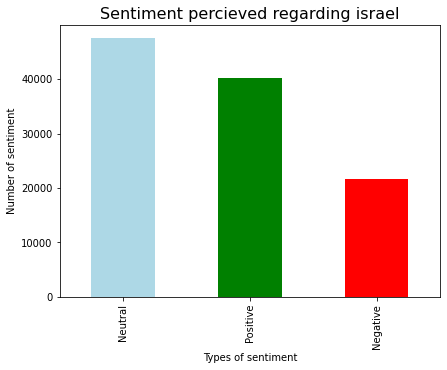

In [ ]:
# plotting bar chart for the Sentiment
plt.subplot(1,2,1)
sent.plot(kind='bar', color=['lightblue','green','red'], figsize=(15,5))
plt.title('Sentiment percieved regarding israel', fontsize=16)
plt.xlabel('Types of sentiment')
plt.ylabel('Number of sentiment');

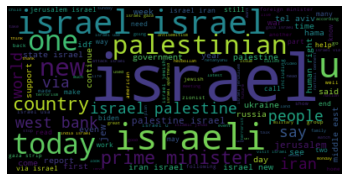

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a word cloud object
wordcloud = WordCloud().generate(tweets_string)

# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
tweets.to_csv('full_data_set_18_01_12_30.csv')

In [ ]:
tweets.columns.to_list()

['tweet.id',
 'tweet.date',
 'tweet.content',
 'tweet.hashtags',
 'tweet.sourceLabel',
 'tweet.place',
 'tweet.retweetCount',
 'tweet.likeCount',
 'tweet.replyCount',
 'tweet.quoteCount',
 'tweet.user.friendsCount',
 'tweet.user.followersCount',
 'tweet.user.statusesCount',
 'tweet.user.favouritesCount',
 'tweet.user.listedCount',
 'tweet.user.verified',
 'tweet.user.created',
 'Tweet.User.TwitterHandle',
 'hashtags',
 'place',
 'Tweet.User_id',
 'tweet.date.Hour',
 'tweet.date.Year',
 'tweet.date.Month',
 'tweet.date.MonthName',
 'tweet.date.MonthDay',
 'tweet.date.DayName',
 'tweet.date.Week',
 'tweet.user.created.Hour',
 'tweet.user.created.Year',
 'tweet.user.created.Month',
 'tweet.user.created.MonthName',
 'tweet.user.created.MonthDay',
 'tweet.user.created.DayName',
 'tweet.user.created.Week',
 'tweet.Location_logged',
 'processed_tweet',
 'Polarity',
 'Sentiment',
 'engagement_rate']

In [ ]:
tweets.columns.to_list()

['tweet.id',
 'tweet.date',
 'tweet.content',
 'tweet.hashtags',
 'tweet.sourceLabel',
 'tweet.place',
 'tweet.retweetCount',
 'tweet.likeCount',
 'tweet.replyCount',
 'tweet.quoteCount',
 'tweet.user.friendsCount',
 'tweet.user.followersCount',
 'tweet.user.statusesCount',
 'tweet.user.favouritesCount',
 'tweet.user.listedCount',
 'tweet.user.verified',
 'tweet.user.created',
 'Tweet.User.TwitterHandle',
 'hashtags',
 'place',
 'Tweet.User_id',
 'tweet.date.Hour',
 'tweet.date.Year',
 'tweet.date.Month',
 'tweet.date.MonthName',
 'tweet.date.MonthDay',
 'tweet.date.DayName',
 'tweet.date.Week',
 'tweet.user.created.Hour',
 'tweet.user.created.Year',
 'tweet.user.created.Month',
 'tweet.user.created.MonthName',
 'tweet.user.created.MonthDay',
 'tweet.user.created.DayName',
 'tweet.user.created.Week',
 'tweet.Location_logged',
 'processed_tweet',
 'Polarity',
 'Sentiment',
 'engagement_rate']

# **Creating Dataframes for further analysis **

In [ ]:
tweet_stats = full_data[[
 'tweet.date',
 'tweet.id',
 'Tweet.User_id',
 'tweet.retweetCount',
 'tweet.likeCount',
 'tweet.replyCount',
 'Polarity',
 'engagement_rate']]
tweet_stats.to_csv('tweet_stats_BI.csv')

In [ ]:
full_data = pd.read_csv('/content/full_data.csv')

In [ ]:
user_profile = full_data[[
 'Tweet.User_id',
 'tweet.user.verified',
 'Tweet.User.TwitterHandle',
 'tweet.user.created',
 'tweet.user.friendsCount',
 'tweet.user.followersCount',
 'tweet.user.statusesCount',
 'tweet.user.listedCount',
 'tweet.user.created.Hour',
 'tweet.user.created.Year',
 'tweet.user.created.Month',
 'tweet.user.created.MonthName',
 'tweet.user.created.MonthDay',
 'tweet.user.created.DayName',
 'tweet.user.created.Week']]
user_profile = user_profile.drop_duplicates(subset='Tweet.User_id', keep='first')
user_profile.to_csv('User_Profile_BI.csv')

In [ ]:
tweet_profile_BI = full_data[[
 'tweet.id',
 'Tweet.User_id',
 'Tweet.User.TwitterHandle',
 'tweet.Location_logged',
 'tweet.content',
 'processed_tweet',
 'tweet.date',
 'tweet.user.favouritesCount',
 'tweet.quoteCount',
 'tweet.date.Hour',
 'tweet.date.Year',
 'tweet.date.Month',
 'tweet.date.MonthName',
 'tweet.date.MonthDay',
 'tweet.date.DayName',
 'tweet.date.Week',
 'tweet.hashtags',
 'tweet.sourceLabel',
 'Sentiment']]
tweet_profile_BI.to_csv('tweet_profile_BI.csv')

In [ ]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109487 entries, 0 to 109486
Data columns (total 41 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Unnamed: 0                    109487 non-null  int64  
 1   tweet.id                      109487 non-null  int64  
 2   tweet.date                    109487 non-null  object 
 3   tweet.content                 109487 non-null  object 
 4   tweet.hashtags                109487 non-null  object 
 5   tweet.sourceLabel             109487 non-null  object 
 6   tweet.place                   109487 non-null  object 
 7   tweet.retweetCount            109487 non-null  float64
 8   tweet.likeCount               109487 non-null  float64
 9   tweet.replyCount              109487 non-null  float64
 10  tweet.quoteCount              109487 non-null  float64
 11  tweet.user.friendsCount       109487 non-null  float64
 12  tweet.user.followersCount     109487 non-nul

In [ ]:
tweets.to_csv('full_data.csv')